## Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

### Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

### Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

# 1. Preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import  make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col='datetime', parse_dates=[0])

In [3]:
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [6]:
df = df.resample('H').sum()

In [7]:
df.tail()

,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


Our data is not missing any values and is resampled by hour. Next, we will create features for our data using both a rolling mean and lag metrics.

# 2. Analysis

In [8]:
df.dropna(inplace=True)
decomposed = seasonal_decompose(df)

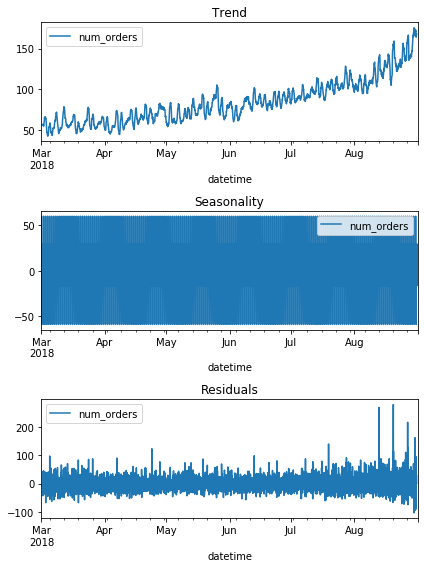

In [9]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

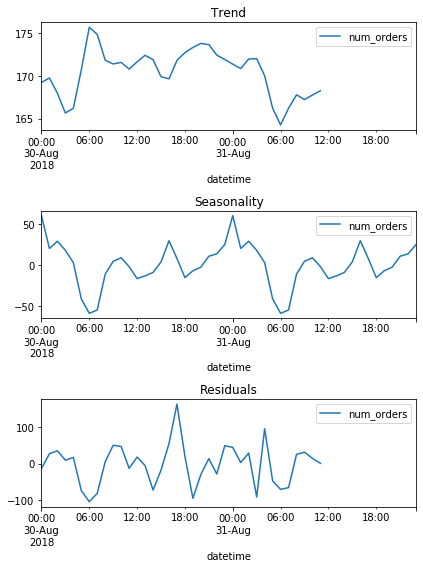

In [10]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend['2018-08-30':'2018-08-31'].plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-08-30':'2018-08-31'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid['2018-08-30':'2018-08-31'].plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

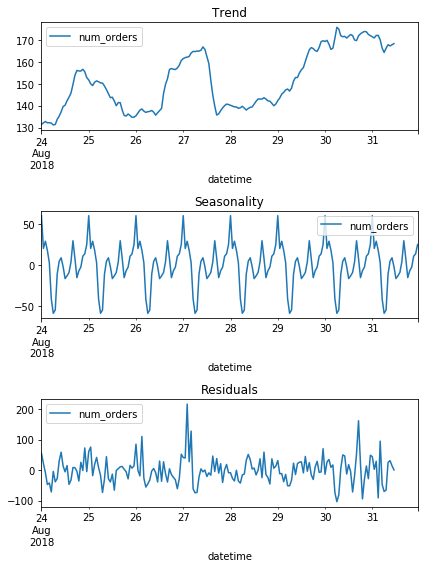

In [11]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend['2018-08-24':'2018-08-31'].plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-08-24':'2018-08-31'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid['2018-08-24':'2018-08-31'].plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Looking at the entire dataset, we see the hourly orders have increased pretty steadily over the course of the year. Seasonality is crowded considering the amount of data included. 

Just looking at the final days in the series, we can observe similar movement during certain times with seasonality. This should help with predictions. Additionally, we can observe similar movement with trends. 

Finally, I took a closer look at just a week of data. This suggests a trend with certain days resulting in more orders than others. And, we see a more clear seasonality on the data. 

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [13]:
make_features(df, 28, 7)

In [14]:
df.tail()

,num_orders,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-31 19:00:00,136,8,31,19,4,207.0,217.0,197.0,116.0,133.0,...,246.0,158.0,198.0,142.0,72.0,177.0,342.0,254.0,156.0,167.428571
2018-08-31 20:00:00,154,8,31,20,4,136.0,207.0,217.0,197.0,116.0,...,276.0,246.0,158.0,198.0,142.0,72.0,177.0,342.0,254.0,167.428571
2018-08-31 21:00:00,159,8,31,21,4,154.0,136.0,207.0,217.0,197.0,...,194.0,276.0,246.0,158.0,198.0,142.0,72.0,177.0,342.0,165.714286
2018-08-31 22:00:00,223,8,31,22,4,159.0,154.0,136.0,207.0,217.0,...,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,177.0,169.428571
2018-08-31 23:00:00,205,8,31,23,4,223.0,159.0,154.0,136.0,207.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,184.714286


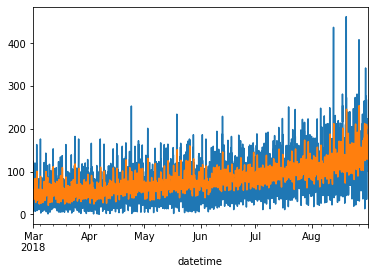

In [15]:
df['num_orders'].plot()
df['rolling_mean'].plot()

With the features created, we can now go about training our models. I went with a lag of 28 hours and a 7-hour rolling mean to explore weekly figures for these orders. We can see day-to-day numbers can vary significantly, so creating these features can help us get a working model in place. 

Simply plotting our rolling mean vs. our original numbers, we also see how, despite being busy, the data tends to move somewhat consistently.

# 3. Training

In [16]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
features_test = test.drop('num_orders', axis=1)
target_train = train['num_orders']
target_test = test['num_orders']

In [17]:
scorer = make_scorer(mean_squared_error, greater_is_better= False)

In [18]:
model = LinearRegression()

In [19]:
tss = TimeSeriesSplit(n_splits=5)

In [20]:
score = cross_val_score(model, features_train, target_train, scoring=scorer, cv=tss)
print('Average MSE:', pd.np.mean(score))

Average MSE: -718.0871419632105


In [21]:
model.fit(features_train, target_train)
predict = model.predict(features_test)

In [22]:
rmse = pd.np.sqrt(mean_squared_error(target_test, predict))
rmse

46.5206518508861

In [23]:
rfg = RandomForestRegressor(random_state=47)

In [24]:
score = cross_val_score(rfg, features_train, target_train, scoring=scorer, cv=tss)
print('Average Model Score:', pd.np.mean(score))

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

Average Model Score: -685.3860213089802


In [25]:
rfg.fit(features_train, target_train)
predict = rfg.predict(features_test)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [26]:
rmse = pd.np.sqrt(mean_squared_error(target_test, predict))
rmse

43.799570495218454

We see initially that linear regression performs similarly to random forest. Despite this, I expect some hyperparameter tuning will allow us to reach a higher level of performance on Random Forest, making it the clear winner. 

# 4. Testing

In [27]:
for estims in range(50, 101, 10):
    model = RandomForestRegressor(random_state=47, n_estimators=estims)
    score = cross_val_score(model, features_train, target_train, scoring=scorer, cv=tss, n_jobs=-1)
    print("n_estimators =", estims, ":", pd.np.sqrt(-score.mean()))

n_estimators = 50 : 25.587829922089245
n_estimators = 60 : 25.534359201493213
n_estimators = 70 : 25.500385533339646
n_estimators = 80 : 25.523163092802506
n_estimators = 90 : 25.52192693907836
n_estimators = 100 : 25.484863247898332


In [28]:
for depth in range(10, 51, 10):
    model = RandomForestRegressor(random_state=47, n_estimators=100, max_depth=depth)
    score = cross_val_score(model, features_train, target_train, scoring=scorer, cv=tss, n_jobs=-1)
    print("max_depth=", depth, ":", pd.np.sqrt(-score.mean()))

max_depth= 10 : 25.685624374171045
max_depth= 20 : 25.42770910425412
max_depth= 30 : 25.489132818938025
max_depth= 40 : 25.484863247898332
max_depth= 50 : 25.484863247898332


In [29]:
for leaves in range(2, 6, 1):
    model = RandomForestRegressor(random_state=47, n_estimators=50, max_depth=20, min_samples_leaf=leaves)
    score = cross_val_score(model, features_train, target_train, scoring=scorer, cv=tss, n_jobs=-1)
    print("leaves =", leaves, ":", pd.np.sqrt(-score.mean()))

leaves = 2 : 25.592572120796113
leaves = 3 : 25.68142139654624
leaves = 4 : 25.69505589282041
leaves = 5 : 25.739071806606194


In [30]:
model = RandomForestRegressor(random_state=47, n_estimators=50, max_depth=20, min_samples_leaf=1)
model.fit(features_train, target_train)
predict = model.predict(features_test)
rmse = pd.np.sqrt(mean_squared_error(target_test, predict))
print('Final Model RMSE:', rmse)

Final Model RMSE: 41.373952343535315


Based on some hyperparameter tuning, we find a random forest with an RMSE of only 41.38. 
    
I would recommend using this model for the most accurate results: model = RandomForestRegressor(n_estimators=50, max_depth=30, min_samples_leaf=2)
With this in place, we can predict the number of orders with considerable reliability. 